In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
from make_datasets import three_planes,dollarsign,roll_and_plane,five_affine_subspaces
from sklearn.datasets import make_circles,make_swiss_roll
from sklearn.cluster import SpectralClustering,KMeans,AgglomerativeClustering
from clustering import DiffusionGeometrySpectralClustering
from metric import acc
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.path.join(os.getcwd(), "smmc v-1.0"), nargout=0)

# Tests 

Evaluate the performance of the diffusion geometry-based model on five synthetic datasets.

## 1. Three planes

In [5]:
X_list = []
y_list = []

n_tests = 10

for i in range(n_tests):
    X,y = three_planes(n_points = 600, random_state = 42 + i)
    X_list.append(X)
    y_list.append(y)

In [6]:
# for figure 3 data
fig3_data = {}
fig3_data[0] = X_list[-1]

In [7]:
## k-means
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    kmeans = KMeans(
        n_clusters=3,       
        init='random',
        random_state=42   
    )
    y_pred = kmeans.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.349 ± 0.005, Run time: 0.131


In [8]:
## spectral clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    sc = SpectralClustering(
        n_clusters=3,          
        affinity='rbf', 
        assign_labels='kmeans',
        gamma=0.001,
        random_state=42
    )
    y_pred = sc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.404 ± 0.006, Run time: 0.120


In [9]:
## Hierarchical Clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    hc = AgglomerativeClustering(
        n_clusters=3, 
        metric='euclidean', 
        linkage='ward'
    )
    y_pred = hc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.392 ± 0.027, Run time: 0.014


In [10]:
## SMMC
acc_list = []
runtime_list = []
for i in range(n_tests):
    X_matlab = matlab.double(X_list[i].T.tolist())
    y_pred , _, _, _, run_time, _, _ = eng.smmc(
        X_matlab,             
        matlab.double([3]),   # nClusts
        matlab.double([2]),   # ppca_dim
        matlab.double([6]),   # M
        matlab.double([30]),  # K 
        matlab.double([8]),   # o
        matlab.double([42]),
        nargout=7
    )
    y_pred = np.array(y_pred)
    runtime_list.append(run_time)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.875 ± 0.237, Run time: 0.852


In [11]:
## DGMMSC
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    y_pred = DiffusionGeometrySpectralClustering(X_list[i],3,M = 9, K = 60, o = 4, random_state = 42)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/it]

ACC interval: 0.997 ± 0.003, Run time: 5.747


## 2. Dollar sign & Swiss roll

In [13]:
X_list = []
y_list = []

n_tests = 10

np.random.seed(42)
for i in range(n_tests):
    ## generate dollar shape
    Xd, Y, labels_d = dollarsign(n_points=1200,seed=42+i)
    ## generate swiss roll 
    Xs, ts = make_swiss_roll(n_samples=600,random_state=42+i)
    x = Xs[:, 0]
    x_scaled = 2*(x - x.min()) / (x.max() - x.min()) + 2
    Xs[:, 0] = x_scaled
    y = Xs[:, 1]
    y_scaled = (y - y.min()) / (y.max() - y.min())
    Xs[:, 1] = y_scaled
    z = Xs[:, 2]
    z_scaled = 4 * (z - z.min()) / (z.max() - z.min()) - 2
    Xs[:, 2] = z_scaled
    ## make whole point cloud and shuffle
    X = np.vstack((Xd, Xs))
    y = np.concatenate([labels_d,np.ones(Xs.shape[0])*2])
    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    y = y[perm]
    
    X_list.append(X)
    y_list.append(y)

In [14]:
fig1_data = {'X':X_list[0], 'y':y_list[0]}

In [15]:
fig3_data[1] = X_list[-1]

In [16]:
## k-means
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    kmeans = KMeans(
        n_clusters=3,      
        init='random',
        random_state=42     
    )
    y_pred = kmeans.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.680 ± 0.007, Run time: 0.039


In [17]:
fig4_data = {}
fig4_data[0] = {}
fig4_data[0][0] = y_pred

In [18]:
## spectral clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    sc = SpectralClustering(
        n_clusters=3,         
        affinity='rbf',  
        assign_labels='kmeans', 
        gamma=0.1,
        random_state=42
    )
    y_pred = sc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.680 ± 0.008, Run time: 1.001


In [19]:
fig4_data[0][1] = y_pred

In [20]:
## Hierarchical Clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    hc = AgglomerativeClustering(
        n_clusters=3, 
        metric='euclidean', 
        linkage='ward'
    )
    y_pred = hc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.672 ± 0.010, Run time: 0.123


In [21]:
## SMMC
acc_list = []
runtime_list = []
for i in range(n_tests):
    X_matlab = matlab.double(X_list[i].T.tolist())
    y_pred , _, _, _, run_time, _, _ = eng.smmc(
        X_matlab,             
        matlab.double([3]),   # nClusts
        matlab.double([2]),   # ppca_dim
        matlab.double([20]),  # M
        matlab.double([15]),  # K
        matlab.double([8]),   # o
        matlab.double([42]),
        nargout=7
    )
    y_pred = np.array(y_pred)
    runtime_list.append(run_time)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.725 ± 0.093, Run time: 4.348


In [22]:
## DGMMSC
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    y_pred = DiffusionGeometrySpectralClustering(X_list[i],3,M = 15, K = 36, o = 4, random_state = 42)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.71s/it]

ACC interval: 1.000 ± 0.000, Run time: 15.432


In [23]:
fig4_data[0][2] = y_pred

## 3. Swiss roll & Plane

In [25]:
X_list = []
y_list = []

n_tests = 10

for i in range(n_tests):
    X,y = roll_and_plane(n_roll=1200, n_plane=600,random_state = 42+i) 
    X_list.append(X)
    y_list.append(y)

In [26]:
fig3_data[2] = X_list[-1]

In [27]:
## k-means
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    kmeans = KMeans(
        n_clusters=2,       
        init='random',
        random_state=42     
    )
    y_pred = kmeans.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.614 ± 0.012, Run time: 0.035


In [28]:
fig4_data[1] = {}
fig4_data[1][0] = y_pred

In [29]:
## spectral clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    sc = SpectralClustering(
        n_clusters=2,          
        affinity='rbf', 
        assign_labels='kmeans', 
        gamma=0.01,
        random_state=42
    )
    y_pred = sc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.642 ± 0.010, Run time: 0.990


In [30]:
fig4_data[1][1] = y_pred

In [31]:
## Hierarchical Clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    hc = AgglomerativeClustering(
        n_clusters=3, 
        metric='euclidean', 
        linkage='ward'
    )
    y_pred = hc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.508 ± 0.060, Run time: 0.128


In [32]:
## SMMC
acc_list = []
runtime_list = []
for i in range(n_tests):
    X_matlab = matlab.double(X_list[i].T.tolist())
    y_pred , _, _, _, run_time, _, _ = eng.smmc(
        X_matlab,             
        matlab.double([2]),   # nClusts
        matlab.double([2]),   # ppca_dim
        matlab.double([20]),  # M
        matlab.double([15]),  # K
        matlab.double([8]),   # o
        matlab.double([42]),
        nargout=7
    )
    runtime_list.append(run_time)
    y_pred = np.array(y_pred)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.804 ± 0.177, Run time: 3.735


In [33]:
## DGMMSC
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    y_pred = DiffusionGeometrySpectralClustering(X_list[i],2,M = 6, K = 12, o = 8,random_state = 42)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.41s/it]

ACC interval: 0.999 ± 0.001, Run time: 15.148


In [34]:
fig4_data[1][2] = y_pred

## 4. Two circles

In [36]:
X_list = []
y_list = []

n_tests = 10

for i in range(n_tests):
    X,y = make_circles(n_samples=200, noise=0.03, factor=0.5, random_state=42+i)
    X_list.append(X)
    y_list.append(y)

In [37]:
fig3_data[3] = X_list[-1]

In [38]:
## k-means
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    kmeans = KMeans(
        n_clusters=2,       
        random_state=42     
    )
    y_pred = kmeans.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.504 ± 0.005, Run time: 0.004


In [39]:
## spectral clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    sc = SpectralClustering(
        n_clusters=2,          
        affinity='rbf', 
        gamma=100,
        random_state=42
    )
    y_pred = sc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 1.000 ± 0.000, Run time: 0.069


In [40]:
## Hierarchical Clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    hc = AgglomerativeClustering(
        n_clusters=2, 
        metric='euclidean', 
        linkage='ward'
    )
    y_pred = hc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.523 ± 0.019, Run time: 0.003


In [41]:
## SMMC
acc_list = []
runtime_list = []
for i in range(n_tests):
    X_matlab = matlab.double(X_list[i].T.tolist())
    y_pred , _, _, _, run_time, _, _ = eng.smmc(
        X_matlab,             
        matlab.double([2]),   # nClusts
        matlab.double([1]),   # ppca_dim
        matlab.double([8]),  # M
        matlab.double([6]),  # K
        matlab.double([4]),   # o
        matlab.double([42]),
        nargout=7
    )
    runtime_list.append(run_time)
    y_pred = np.array(y_pred)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 1.000 ± 0.000, Run time: 0.270


In [42]:
## DGMMSC
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    y_pred = DiffusionGeometrySpectralClustering(X_list[i],2,M = 8, K = 10, o = 4,random_state = 42)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]

ACC interval: 1.000 ± 0.000, Run time: 0.846


## 5. Five-affine-subspaces

In [44]:
X_list = []
y_list = []

n_tests = 10

for i in range(n_tests):
    X,y = five_affine_subspaces(n_points=500,random_state=42+i)
    X_list.append(X)
    y_list.append(y)

In [45]:
fig3_data[4] = X_list[-1]

In [46]:
## k-means
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    kmeans = KMeans(
        n_clusters=5, 
        init='random',
        random_state=42    
    )
    y_pred = kmeans.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.704 ± 0.001, Run time: 0.039


In [47]:
## spectral clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    sc = SpectralClustering(
        n_clusters=5,         
        affinity='rbf',  
        assign_labels='kmeans', 
        gamma=0.1,
        random_state=42
    )
    y_pred = sc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.662 ± 0.003, Run time: 0.114


In [48]:
## Hierarchical Clustering
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    hc = AgglomerativeClustering(
        n_clusters=5, 
        metric='euclidean', 
        linkage='ward'
    )
    y_pred = hc.fit_predict(X_list[i])
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.718 ± 0.028, Run time: 0.011


In [49]:
## SMMC
acc_list = []
runtime_list = []
for i in range(n_tests):
    X_matlab = matlab.double(X_list[i].T.tolist())
    y_pred , _, _, _, run_time, _, _ = eng.smmc(
        X_matlab,             
        matlab.double([5]),   # nClusts
        matlab.double([1]),   # ppca_dim
        matlab.double([20]),  # M
        matlab.double([20]),  # K
        matlab.double([8]),   # o
        matlab.double([42]),
        nargout=7
    )
    y_pred = np.array(y_pred)
    runtime_list.append(run_time)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

ACC interval: 0.967 ± 0.082, Run time: 0.666


In [50]:
## DGMMSC
acc_list = []
runtime_list = []
for i in range(n_tests):
    time_start = time.time()
    y_pred = DiffusionGeometrySpectralClustering(X_list[i],5,M = 5, K = 20,o = 8, random_state = 42)
    runtime_list.append(time.time() - time_start)
    acc_list.append(acc(y_pred, y_list[i]))
print(f"ACC interval: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}, Run time: {np.mean(runtime_list):.3f}")

Spectral Clustering: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.54it/s]

ACC interval: 0.997 ± 0.007, Run time: 2.790


## Figures

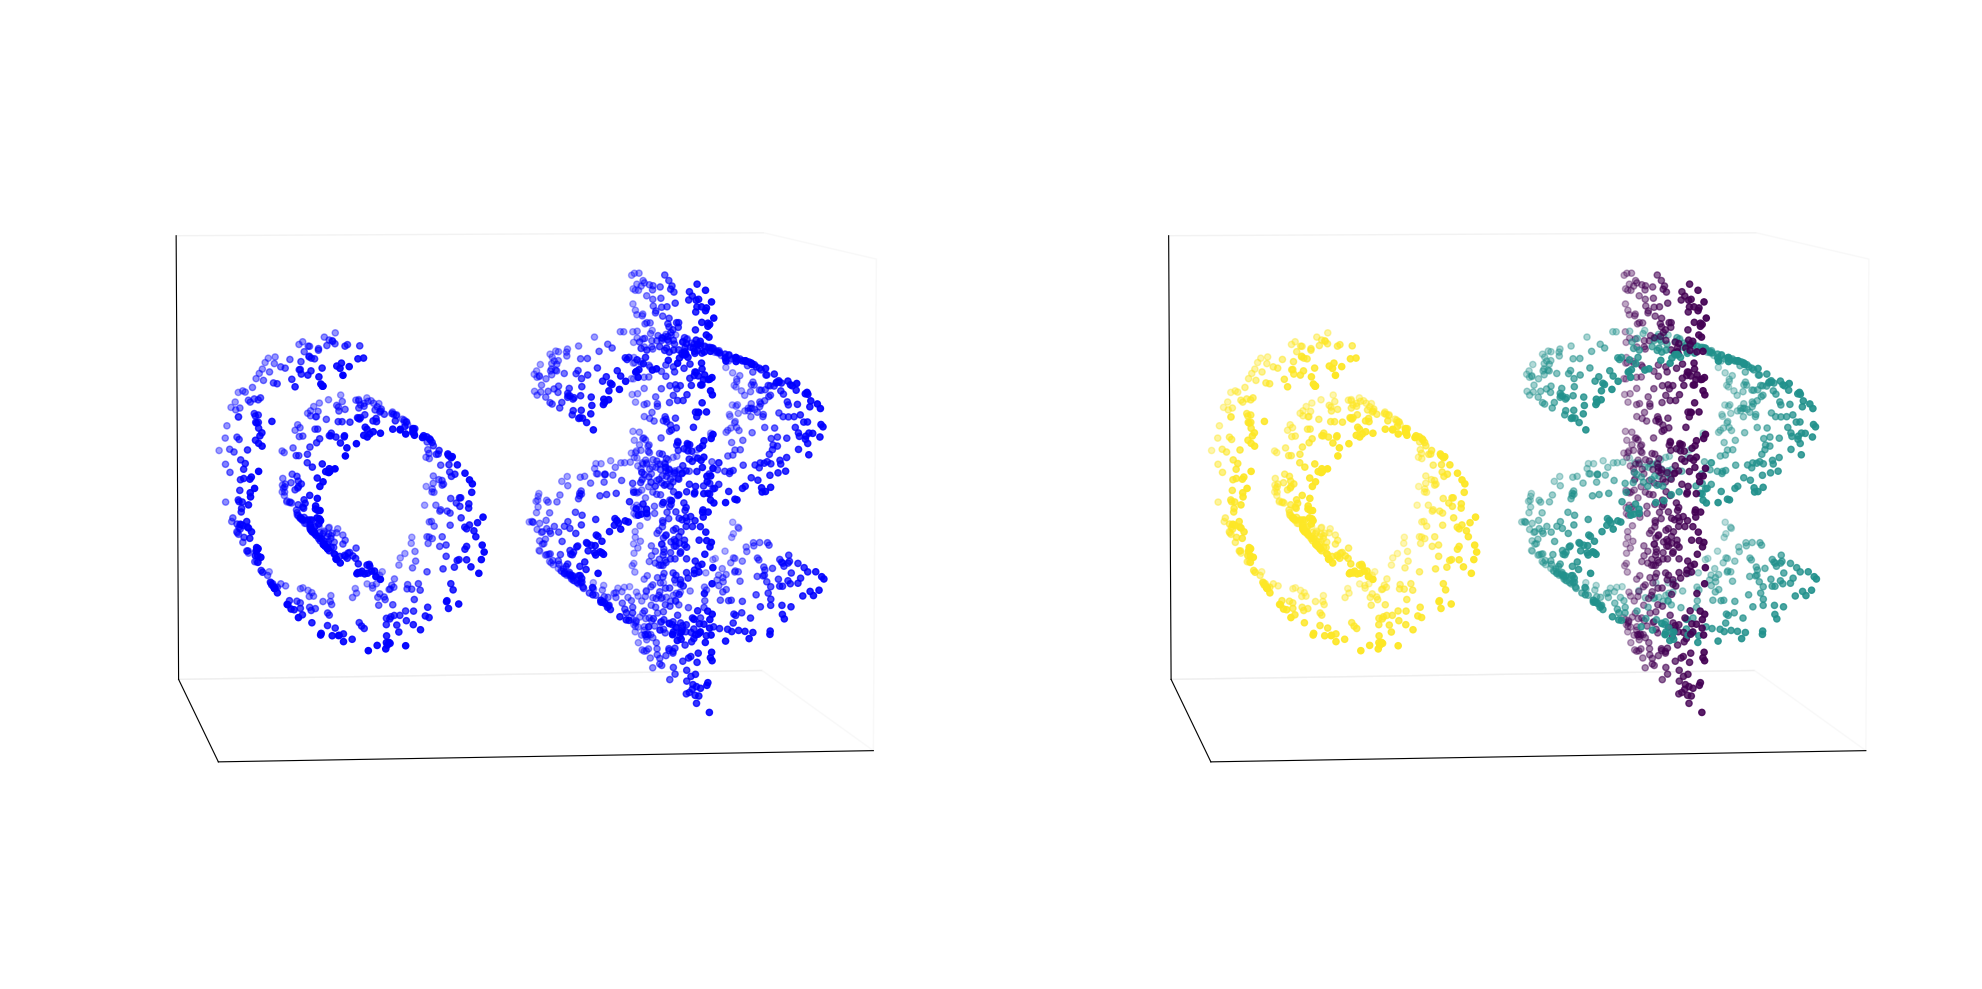

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
axes = axes.flatten()

ax = axes[0]
scatter = ax.scatter(fig1_data['X'][:,0], fig1_data['X'][:,1], fig1_data['X'][:,2], c='blue', s=20)
ax.view_init(elev=5, azim=83)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax = axes[1]
scatter = ax.scatter(fig1_data['X'][:,0], fig1_data['X'][:,1], fig1_data['X'][:,2], c=fig1_data['y'], s=20)
ax.view_init(elev=5, azim=83)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.tight_layout()
plt.savefig('figure1.png', dpi=600, bbox_inches='tight')
plt.show()

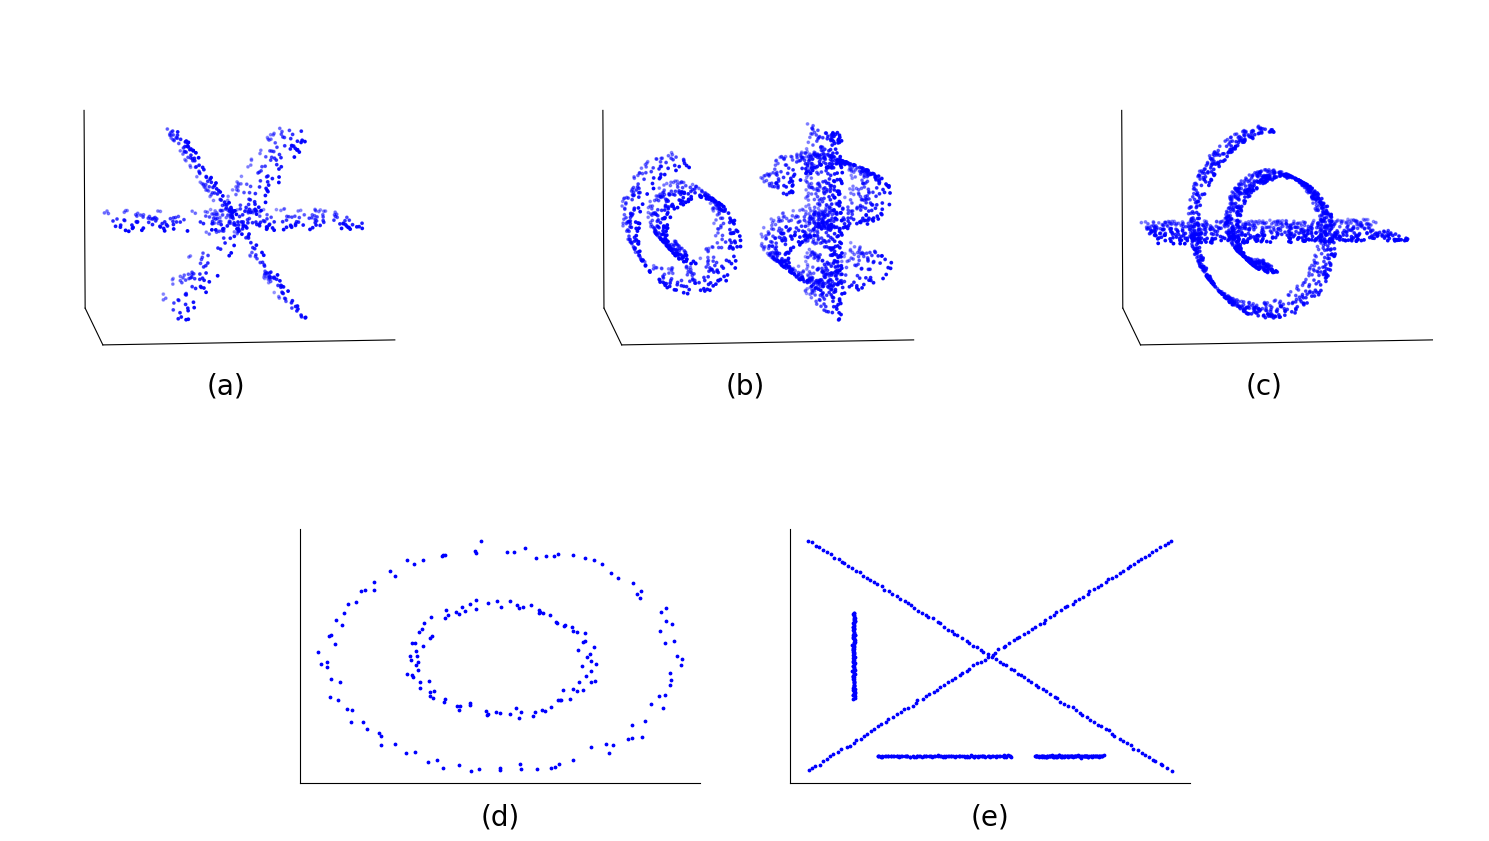

In [53]:
fig = plt.figure(figsize=(15, 10))
title_list = ['a','b','c','d','e']
outer = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3, 1])

gs_top = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[0])

gs_bottom = gridspec.GridSpecFromSubplotSpec(
    1, 4, subplot_spec=outer[1], width_ratios=[1, 2, 2, 1], wspace=0.3
)

# top 3 figure
for i in range(3):
    ax = fig.add_subplot(gs_top[0, i], projection='3d')
    ax.scatter(fig3_data[i][:,0], fig3_data[i][:,1], fig3_data[i][:,2], c='blue', s=3)
    ax.view_init(elev=5, azim=83)
    ax.xaxis.pane.set_visible(False)
    ax.yaxis.pane.set_visible(False)
    ax.zaxis.pane.set_visible(False)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.line.set_visible(True)
    ax.yaxis.line.set_visible(True)
    ax.zaxis.line.set_visible(True)
    ax.set_title(f"({title_list[i]})", y=0.1, fontsize=20)
# bottom 2 figure
for i in range(3, 5):
    ax = fig.add_subplot(gs_bottom[0, i-2])
    ax.scatter(fig3_data[i][:,0], fig3_data[i][:,1], c='blue', s=3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"({title_list[i]})", y= -0.2 , fontsize=20)
    
plt.tight_layout()
plt.savefig("figure3.png", dpi=600, bbox_inches="tight")
plt.show()


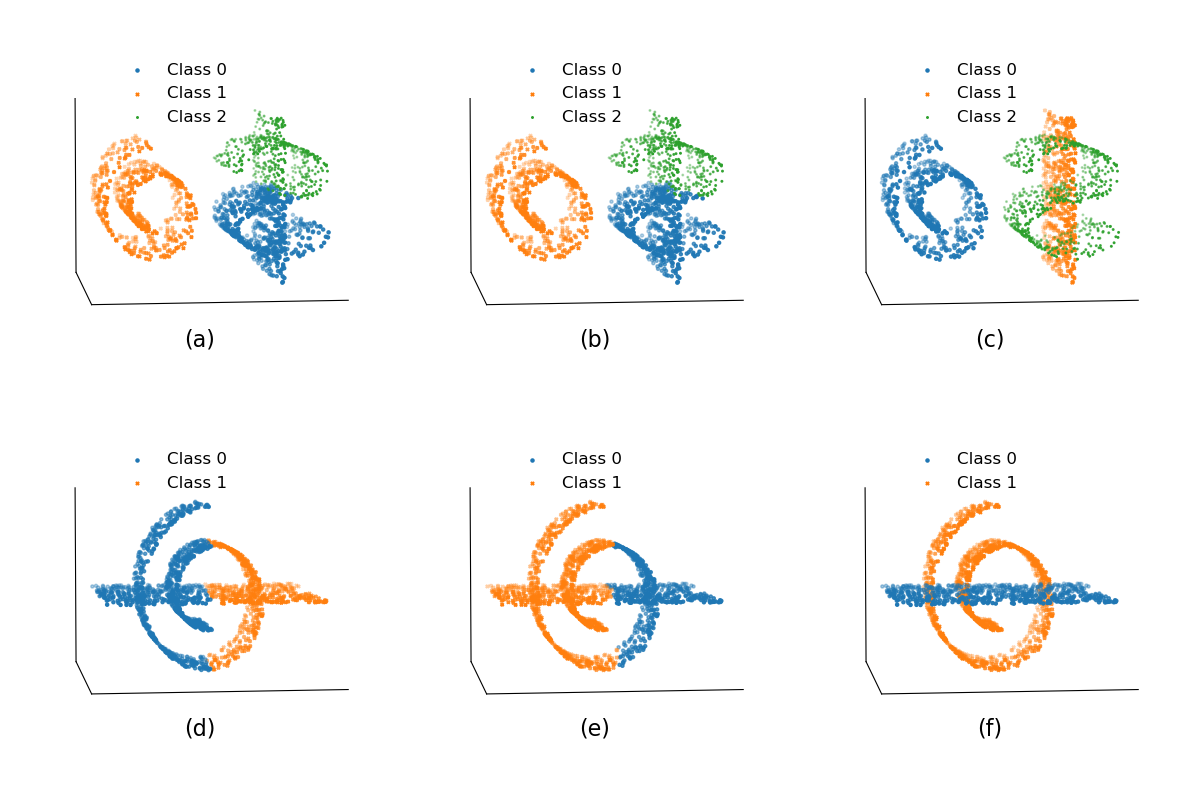

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})
axes = axes.flatten()
title_list = ['a','b','c','d','e','f']
markers = ['o', 'x', '.'] 

for i in range(6):
    ax = axes[i]
    
    X = fig3_data[i//3+1]
    y = fig4_data[i//3][i%3]

    for j, cat in enumerate(np.unique(y)):
        mask = (y == cat)
        marker = markers[j % len(markers)]   
        ax.scatter(
            X[mask,0], X[mask,1], X[mask,2],
            s=5, marker=marker, label=f'Class {cat}'
        )

    ax.view_init(elev=5, azim=83)
    ax.xaxis.pane.set_visible(False)
    ax.yaxis.pane.set_visible(False)
    ax.zaxis.pane.set_visible(False)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.line.set_visible(True)
    ax.yaxis.line.set_visible(True)
    ax.zaxis.line.set_visible(True)

    ax.legend(loc="upper left", bbox_to_anchor=(0.25, 0.90),
              fontsize=12, frameon=False)

    ax.set_title(f"({title_list[i]})", y= 0.1 , fontsize=16)

plt.tight_layout()
plt.savefig('figure4.png', dpi=600, bbox_inches='tight')
plt.show()
